# 02 DNN

Goal of this notebook:

 - Train a simple feed-forward neural network to discriminate the HH->bbWW signal versus the ttbar->bWbW backgrounds, with 26 event-level variables.
 - Draw the predicted NN score distribution and the ROC curve.
 - Play around with the NN architecture and overlay new training results on the ROC curve.

In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd

# Use boost_histogram to make a histogram
import boost_histogram as bh

import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
# make ROOT-style plots using python package matplotlib
plt.style.use(hep.style.ROOT)

In [2]:
import os
# Determine the base directory and the remote git path
hostname = os.uname()[1]
if 'pku.edu.cn' in hostname: # on PKU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/dihiggs_ntuples/'
elif 'thu' in hostname: # on THU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/dihiggs_ntuples/'
elif hostname.startswith('lxslc'): # on IHEP lxslc
    basedir = '/scratchfs/cms/licq/cmschina/ML/dihiggs_ntuples/'
elif hostname.startswith('lxplus'): # on CERN lxplus
    basedir = '/eos/user/c/coli/cmschina/ML/dihiggs_ntuples/'
else:
    raise RuntimeError('Machine not supported')

# Now we read the ROOT file into pandas dataframe
events_sig = uproot.open(basedir + "hh2b2w.root:tree").arrays(library='pd')
events_bkg = uproot.open(basedir + "ttbar.root:tree").arrays(library='pd')
events = pd.concat([events_sig, events_bkg])

# display event table
events

,event,is_sig,is_bkg,bjet1_pt,bjet1_eta,bjet1_phi,bjet1_eratio,bjet1_mass,bjet1_ncharged,bjet1_nneutrals,...,lep1_eta,lep1_charge,lep1_type,lep2_pt,lep2_phi,lep2_eta,lep2_charge,lep2_type,met,met_phi
0,0,True,False,191.402328,-0.291164,-0.979666,0.289940,16.695002,12,6,...,-0.773752,1,0,17.508558,1.165262,-0.711694,-1,0,233.613846,2.300718
1,1,True,False,68.452507,-1.215415,2.387005,0.492361,15.253864,10,10,...,0.606327,1,1,50.567219,-1.089323,0.409210,-1,1,102.682526,-0.004101
2,2,True,False,152.725433,0.449958,-1.470235,1.215402,12.211457,12,8,...,0.174719,1,1,43.384056,0.584961,0.624317,-1,0,57.796436,0.935978
3,3,True,False,107.360390,0.124028,-1.175005,0.000000,6.060685,6,4,...,0.354157,1,1,26.664654,2.175398,0.556468,-1,1,65.674774,1.417736
4,4,True,False,97.040932,2.160315,-2.940341,0.000000,10.475123,10,14,...,1.324205,-1,1,29.825296,0.306789,0.310836,1,0,94.994255,-3.043913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149995,False,True,169.980515,-0.147777,2.985398,0.209411,27.176857,12,8,...,0.043173,-1,1,92.388741,-0.697610,0.483596,1,1,131.839859,-0.000835
149996,149996,False,True,47.205002,1.002193,-1.613720,0.000000,9.505911,10,8,...,-1.080385,-1,0,62.515564,0.693190,0.890577,1,0,75.465065,1.878048
149997,149997,False,True,63.940311,0.381228,0.494209,0.166411,8.920477,10,8,...,0.518369,1,0,34.591877,2.737549,-0.180914,-1,1,59.409447,0.176429
149998,149998,False,True,89.012772,-0.562279,-0.638000,0.648749,13.602261,11,12,...,-0.334734,-1,1,20.882822,-3.140386,-1.086141,1,0,44.600636,-1.177096


In [3]:
# Format training variables
X = events.iloc[:, 3:].to_numpy() # training variable starts from the 4th column
y = events.iloc[:, 1:3].to_numpy()

print(X.shape, y.shape)

(300000, 26) (300000, 2)


In [4]:
# Split train:test set as 90:10
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Building a simple neural network

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

# Neural network: a sequence of dense layers
model = Sequential()

# model.add: to add a layer to our neural network
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='softmax'))
# show a summary
model.summary()

# Specify the loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2021-12-12 10:38:12.687217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 10:38:12.687526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-12 10:38:38.851634: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-12 10:38:38.851730: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lxplus775.cern.ch): /proc/driver/nvidia/version does not exist
2021-12-12 10:38:38.959021: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  A

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                540       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 1,002
Trainable params: 1,002
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Start training
history = model.fit(X_train, y_train, epochs=50, batch_size=1024)

Epoch 1/50
264/264 [==============================] - 5s 2ms/step - loss: 2.6207 - accuracy: 0.6129
Epoch 2/50
264/264 [==============================] - 1s 2ms/step - loss: 0.6489 - accuracy: 0.6747
Epoch 3/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5921 - accuracy: 0.7009
Epoch 4/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5828 - accuracy: 0.7046
Epoch 5/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5810 - accuracy: 0.7048
Epoch 6/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5709 - accuracy: 0.7096
Epoch 7/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5693 - accuracy: 0.7100
Epoch 8/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5663 - accuracy: 0.7111
Epoch 9/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5677 - accuracy: 0.7095
Epoch 10/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5595 - accuracy: 0.7132

In [7]:
# Then evaluate accuracy on the test set
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

938/938 [==============================] - 1s 1ms/step - loss: 0.4260 - accuracy: 0.8006
Accuracy: 80.06


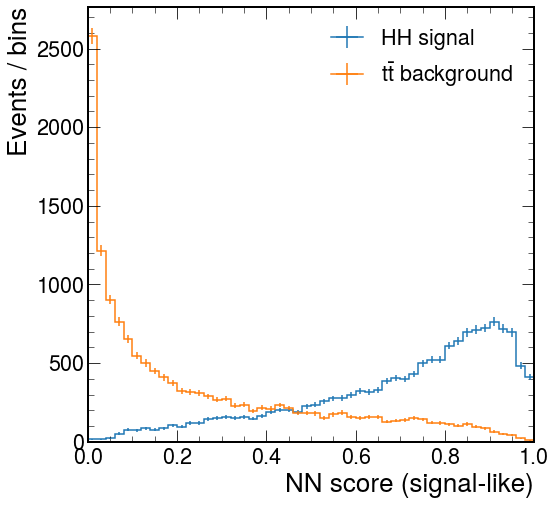

In [8]:
# Draw the predicted score distribution

y_pred = model.predict(X_test)
y_pred_sig_score = y_pred[:, 0] # score predicted for each event to be a "signal event"

sig_index = np.where(y_test[:, 0] == True)[0]
bkg_index = np.where(y_test[:, 0] == False)[0]
f, ax = plt.subplots(figsize=(8, 8))
for idx, lab in zip([sig_index, bkg_index], ['HH signal', r'$t\bar{t}$ background']):
    hist = bh.Histogram(bh.axis.Regular(50, 0., 1.), storage=bh.storage.Weight())
    hist.fill(y_pred_sig_score[idx])
    content, yerr = hist.view().value, np.sqrt(hist.view().variance)
    # plot the histogram
    hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr, label=lab)
ax.set_xlabel('NN score (signal-like)', ha='right', x=1.0)
ax.set_ylabel('Events / bins', ha='right', y=1.0)
ax.set_xlim(0, 1)
ax.legend()

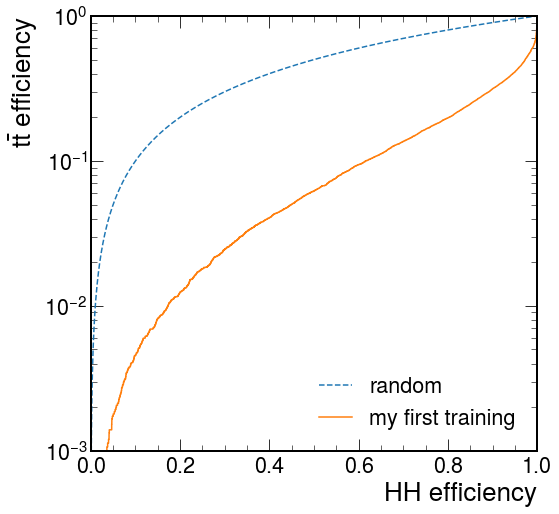

In [9]:
# Draw the ROC curve

import sklearn.metrics as m
fpr, tpr, _thres = m.roc_curve(y_test[:, 0], y_pred[:, 0])

import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
# make ROOT-style plots using python package matplotlib
plt.style.use(hep.style.ROOT)

# Plot the ROC curve
f, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), '--', label='random')
ax.plot(tpr, fpr, label='my first training')
## >>continue to draw your new ROC curves here<<
## ...

## >>or uncomment the lines below to also include the ROC curves from the previous ML tasks<<
# tpr_clf, fpr_clf = np.loadtxt("/data/pubfs/pku_visitor/public_write/ML_tutorial_1stpart/TextData/roc_lr.dat")
# tpr_xgb, fpr_xgb = np.loadtxt("/data/pubfs/pku_visitor/public_write/ML_tutorial_1stpart/TextData/roc_xgb.dat")
# ax.plot(tpr_clf, fpr_clf, label='Logistic Regression')
# ax.plot(tpr_xgb, fpr_xgb, label='XGBoost Classifier')

ax.set_yscale('log'); ax.set_xlim(0, 1); ax.set_ylim(1e-3, 1)
ax.set_xlabel('HH efficiency', ha='right', x=1.0); ax.set_ylabel(r'$t\bar{t}$ efficiency', ha='right', y=1.0)
ax.legend()